## Montar gDrive

In [1]:
from google.colab import drive
 
drive.mount('./gdrive', force_remount=True)
%cd './gdrive/My Drive/Colab Notebooks/dso'

Mounted at ./gdrive
/content/gdrive/My Drive/Colab Notebooks/dso


In [2]:
!pip install -q scikit-learn imbalanced-learn xgboost --upgrade

     |████████████████████████████████| 22.3MB 37.9MB/s 
     |████████████████████████████████| 215kB 51.2MB/s 
     |████████████████████████████████| 157.5MB 41kB/s 


## Importações e Funções

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone


def plot_confusion_matrix(gt, predict, cmap='Blues', title='Matriz de Confusão'):
    print(classification_report(gt, predict, digits=4, zero_division=True))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    g = sns.heatmap(confusion_matrix(gt, predict), fmt='d', square=True, annot=True, cmap=cmap, ax=ax)
    g.set_title(title)
 

def cross_validation(clf, x, y, n_splits=10, n_repeats=3, run_only_once=False, random_state=42):
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    x, y = x.to_numpy(), y.to_numpy()
    gt, predict = [], []

    for i, (train, test) in enumerate(rskf.split(x, y)):
        if i == 0: print(f'Train size: {len(train)}, Test size: {len(test)}')
        print(f'Running: {i + 1} / {rskf.get_n_splits()}')
 
        x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
        
        clf_c = clone(clf)
        clf_c.fit(x_train, np.squeeze(y_train))
 
        gt.extend(y_test)
        predict.extend(clf_c.predict(x_test))
 
        if run_only_once:
            break
 
    return gt, predict, clf_c

## Dataset

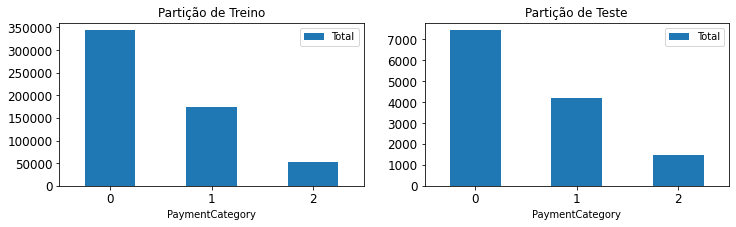

In [11]:
df = pd.read_csv('./data/base4.csv', parse_dates=['DueDate'], low_memory=False)

train = df[df['DueDate'] < '2021-02-01'].drop(['DueDate'], axis=1)
test = df[(df['DueDate'] >= '2021-02-01') & (df['DueDate'] < '2021-03-01')].drop(['DueDate'], axis=1)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

train.groupby(['PaymentCategory']).size().reset_index(name='Total')\
    .plot(title='Partição de Treino', x='PaymentCategory', kind='bar', fontsize=12, rot=0, ax=axes[0])

test.groupby(['PaymentCategory']).size().reset_index(name='Total')\
    .plot(title='Partição de Teste', x='PaymentCategory', kind='bar', fontsize=12, rot=0, ax=axes[1])

## Atributos

In [6]:
y_columns = [
    'PaidLate',
    'PaidLateAM',
    'DaysLate',
    'DaysLateAM',
    'PaymentCategory',
]
 
x_columns = [
    'InvoiceCount',
    'OSInvoiceCount',
    'R_OSInvoiceCount',

    'InvoiceAmount',
    'OSInvoiceAmount',
    'R_OSInvoiceAmount',

    'DaysToDueDate',
    'DaysToEndMonth',

    'WeekdayEndMonth',
    'PartnerCustomer',

    'MAD_DaysLate',
    'MED_DaysLate',

    'MAD_DaysLateAM',
    'MED_DaysLateAM',

    'MAD_OSDaysLate',
    'MED_OSDaysLate',

    'MAD_OSDaysLateAM',
    'MED_OSDaysLateAM',

    'PaidCount',
    'PaidLateCount',
    'PaidLateAMCount',
    'R_PaidLateCount',
    'R_PaidLateAMCount',

    'PaidAmount',
    'PaidLateAmount',
    'PaidLateAMAmount',
    'R_PaidLateAmount',
    'R_PaidLateAMAmount',

    'OSCount',
    'OSLateCount',
    'OSLateAMCount',
    'R_OSLateCount',
    'R_OSLateAMCount',

    'OSAmount',
    'OSLateAmount',
    'OSLateAMAmount',
    'R_OSLateAmount',
    'R_OSLateAMAmount',
]

## Train: Pagamento no prazo x atrasado

Train size: 513243, Test size: 57027
Running: 1 / 30
              precision    recall  f1-score   support

           0     0.9045    0.8780    0.8910     34322
           1     0.8233    0.8598    0.8412     22705

    accuracy                         0.8707     57027
   macro avg     0.8639    0.8689    0.8661     57027
weighted avg     0.8722    0.8707    0.8712     57027



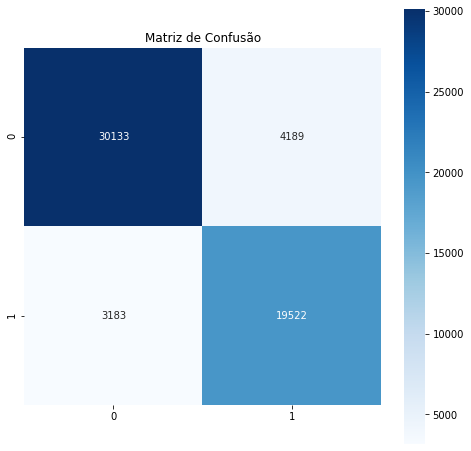

In [8]:
from sklearn.ensemble import RandomForestClassifier

y_train_paidlate = train[y_columns]
x_train_paidlate = train[x_columns]

qt_train_paidlate = RobustScaler(quantile_range=(25.0, 75.0))

x_train_paidlate.iloc[:][:] = qt_train_paidlate.fit_transform(x_train_paidlate.to_numpy())


clf = RandomForestClassifier(n_estimators=100,
                             criterion='entropy',
                             min_samples_split=8,
                             class_weight='balanced',
                             random_state=42)

train_gt_paidlate, train_pred_paidlate, clf = cross_validation(clf, x_train_paidlate, y_train_paidlate['PaidLate'], n_splits=10, n_repeats=3)

plot_confusion_matrix(train_gt_paidlate, train_pred_paidlate, cmap='Blues')

## Test: Pagamento no prazo x atrasado

              precision    recall  f1-score   support

           0     0.8568    0.8174    0.8366      7430
           1     0.7751    0.8217    0.7977      5693

    accuracy                         0.8192     13123
   macro avg     0.8160    0.8195    0.8172     13123
weighted avg     0.8214    0.8192    0.8198     13123



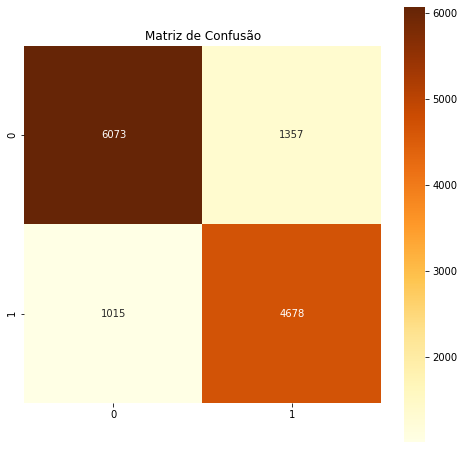

In [14]:
y_test_paidlate = test[y_columns]
x_test_paidlate = test[x_columns]

qt_test_paidlate = RobustScaler(quantile_range=(25.0, 75.0))
x_test_paidlate.iloc[:][:] = qt_test_paidlate.fit_transform(x_test_paidlate.iloc[:].to_numpy())

test_pred_paidlate = clf.predict(x_test_paidlate)

plot_confusion_matrix(y_test_paidlate['PaidLate'], test_pred_paidlate, cmap='YlOrBr')

## Train: Pagamento atrasado no mês de vencimento x atrasado além do mês de vencimento

Train size: 204343, Test size: 22705
Running: 1 / 30
              precision    recall  f1-score   support

           0     0.9269    0.9541    0.9403     17449
           1     0.8312    0.7502    0.7886      5256

    accuracy                         0.9069     22705
   macro avg     0.8790    0.8521    0.8644     22705
weighted avg     0.9047    0.9069    0.9052     22705



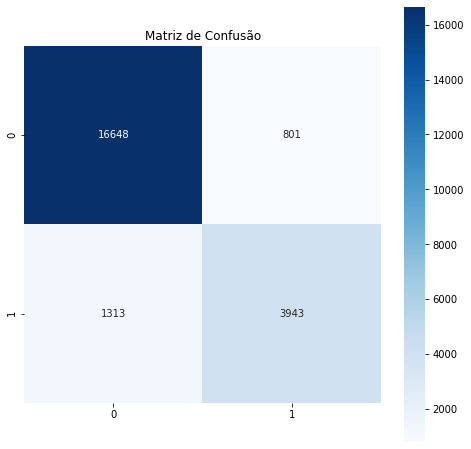

In [15]:
y_train_paidlate_am = train[train['PaidLate'] == 1][y_columns]
x_train_paidlate_am = train[train['PaidLate'] == 1][x_columns]

qt_train_paidlate_am = RobustScaler(quantile_range=(25.0, 75.0))
x_train_paidlate_am.iloc[:][:] = qt_train_paidlate_am.fit_transform(x_train_paidlate_am.to_numpy())


clf = RandomForestClassifier(n_estimators=100,
                             criterion='entropy',
                             min_samples_split=8,
                             class_weight='balanced',
                             random_state=42)


train_gt_paidlate_am, train_pred_paidlate_am, clf = cross_validation(clf, x_train_paidlate_am, y_train_paidlate_am['PaidLateAM'], n_splits=10, n_repeats=3)

plot_confusion_matrix(train_gt_paidlate_am, train_pred_paidlate_am, cmap='Blues')

## Test: Pagamento atrasado no mês de vencimento x atrasado além do mês de vencimento

              precision    recall  f1-score   support

           0     0.9084    0.9251    0.9167      4716
           1     0.7135    0.6664    0.6891      1319

    accuracy                         0.8686      6035
   macro avg     0.8109    0.7958    0.8029      6035
weighted avg     0.8658    0.8686    0.8670      6035



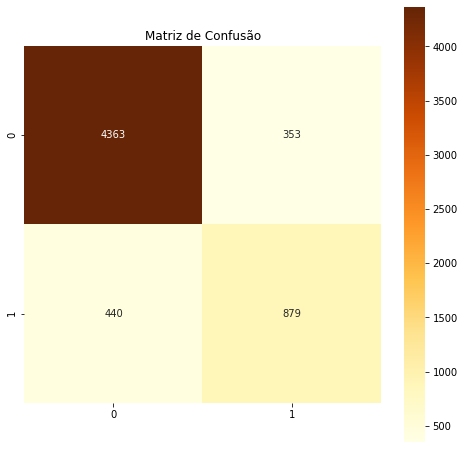

In [16]:
y_test_paidlate_am = test[test_pred_paidlate == 1][y_columns]
x_test_paidlate_am = test[test_pred_paidlate == 1][x_columns]

qt_test_paidlate_am = RobustScaler(quantile_range=(25.0, 75.0))
x_test_paidlate_am.iloc[:][:] = qt_test_paidlate_am.fit_transform(x_test_paidlate_am.iloc[:].to_numpy())

test_pred_paidlate_am = clf.predict(x_test_paidlate_am)

plot_confusion_matrix(y_test_paidlate_am['PaidLateAM'], test_pred_paidlate_am, cmap='YlOrBr')